In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
from bs4 import BeautifulSoup
import pandas as pd
import re

def parse_html_to_dataframe(file_path):
    # Load the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')

    transactions = []

    # Find all divs with the relevant class
    for transaction in soup.find_all('div', class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1'):
        # Extract the full text from the div
        transaction_text = transaction.get_text(separator=" ").strip()

        # Print the transaction text for debugging
        #print("Transaction text:", transaction_text)

        # Regex patterns for different transaction types
        paid_pattern = r'Paid ₹([\d,]+\.\d{2}) to (.+?) using Bank Account (XXXXXX\d{4})'
        sent_pattern = r'Sent ₹([\d,]+\.\d{2}) using Bank Account (XXXXXX\d{4})'
        received_pattern = r'Received ₹([\d,]+\.\d{2})'

        # Attempt to extract the date and time using regex
        date_time_pattern = r'(\d{1,2} \w+ \d{4}, \d{1,2}:\d{2}:\d{2} \w{3})'
        date_time_match = re.search(date_time_pattern, transaction_text)

        if date_time_match:
            date_time = date_time_match.group(1)
            transaction_text = transaction_text[:date_time_match.start()].strip()  # Remove date from the main text for further parsing
            #print("Date and time found:", date_time)

            # Split the date_time into separate components
            date_str, time_str = date_time.split(', ')
            time_str = time_str.strip()  # Clean up the time string
        else:
            #print("No date found for:", transaction_text)
            continue  # Skip this transaction if no date is found

        # Check for Paid transactions
        match = re.search(paid_pattern, transaction_text)
        if match:
            amount = match.group(1)
            payee = match.group(2)
            account = match.group(3)
            transactions.append(['Paid', payee, amount, account, date_str, time_str])
            continue

        # Check for Sent transactions
        match = re.search(sent_pattern, transaction_text)
        if match:
            amount = match.group(1)
            account = match.group(2)
            transactions.append(['Sent', 'N/A', amount, account, date_str, time_str])
            continue

        # Check for Received transactions
        match = re.search(received_pattern, transaction_text)
        if match:
            amount = match.group(1)
            transactions.append(['Received', 'N/A', amount, 'N/A', date_str, time_str])
            continue

        #print("No match found for:", transaction_text)  # Debug unmatched transaction

    # Create a Pandas DataFrame
    df2 = pd.DataFrame(transactions, columns=['Transaction Type', 'Payee', 'Amount', 'Account', 'Date', 'Time'])

    # Convert amount to a numeric value (removing commas)
    df2['Amount'] = df2['Amount'].str.replace(',', '').astype(float)

    # Check for any NaT in the Date and Time columns
    #if df['Date'].isnull().any() or df['Time'].isnull().any():
        #print("Warning: Some date or time entries could not be converted:")
        #print(df[df['Date'].isnull() | df['Time'].isnull()])

    return df2

# Use the function to parse your file
file_path = r'My Activity.html'

df2 = parse_html_to_dataframe(file_path)


# Save the data to a CSV file for further use
df2.to_csv('extracted_transactions.csv', index=False)

df2['Time'] = df2['Time'].str[:-4]
df2['Time'] = pd.to_datetime(df2['Time'], format='%H:%M:%S')


#df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y') cant use this because September is written as Sept and not as Sep
df2['Date'] = pd.to_datetime(df2['Date'], format='mixed')
print(df2['Time'].dtypes)
print(df2.describe())
print(df2.sample(10))
#incase df gets altered by mistake
df = df2.copy()


datetime64[ns]
             Amount                           Date  \
count    435.000000                            435   
mean     328.237655  2024-04-25 19:45:06.206896640   
min        1.000000            2023-11-15 00:00:00   
25%       40.000000            2024-02-04 00:00:00   
50%       70.000000            2024-04-18 00:00:00   
75%      159.500000            2024-07-29 12:00:00   
max    20000.000000            2024-10-19 00:00:00   
std     1247.500894                            NaN   

                                Time  
count                            435  
mean   1900-01-01 15:35:03.871264256  
min              1900-01-01 00:00:47  
25%       1900-01-01 12:15:26.500000  
50%              1900-01-01 16:11:24  
75%       1900-01-01 19:11:13.500000  
max              1900-01-01 23:58:59  
std                              NaN  
    Transaction Type                Payee  Amount     Account       Date  \
310             Sent                  N/A   219.0  XXXXXX6411 2024-02-1

In [ ]:
# prompt: no of null values

# Check for null values in each column
null_counts = df.isnull().sum()
null_counts


,0
Transaction Type,0
Payee,0
Amount,0
Account,0
Date,0
Time,0


    Transaction Type                Payee  Amount     Account       Date  \
0               Paid         Dhinakaran K    40.0  XXXXXX6411 2024-10-19   
1               Paid             ANANDHAN    65.0  XXXXXX6411 2024-10-18   
2               Paid             ANANDHAN    60.0  XXXXXX6411 2024-10-17   
3               Paid             ANANDHAN    10.0  XXXXXX6411 2024-10-15   
4               Paid             ANANDHAN    10.0  XXXXXX6411 2024-10-15   
..               ...                  ...     ...         ...        ...   
430         Received                  N/A   117.0         N/A 2023-11-18   
431             Paid  HOTEL PUNJABI RASOI   840.0  XXXXXX6411 2023-11-18   
432             Paid            All Maart    10.0  XXXXXX6411 2023-11-16   
433             Paid            All Maart    20.0  XXXXXX6411 2023-11-16   
434             Sent                  N/A   197.0  XXXXXX6411 2023-11-15   

                   Time  
0   1900-01-01 12:10:58  
1   1900-01-01 12:04:16  
2   1900-

In [30]:
print(df['Time'])
print(df['Date'])

0     1900-01-01 12:10:58
1     1900-01-01 12:04:16
2     1900-01-01 13:22:18
3     1900-01-01 19:14:24
4     1900-01-01 19:13:54
              ...        
430   1900-01-01 14:41:32
431   1900-01-01 14:38:56
432   1900-01-01 19:20:18
433   1900-01-01 13:16:31
434   1900-01-01 15:33:27
Name: Time, Length: 435, dtype: datetime64[ns]
0     2024-10-19
1     2024-10-18
2     2024-10-17
3     2024-10-15
4     2024-10-15
         ...    
430   2023-11-18
431   2023-11-18
432   2023-11-16
433   2023-11-16
434   2023-11-15
Name: Date, Length: 435, dtype: datetime64[ns]


#Graphs


###No of transactions

##Hourly Graph

In [31]:
# Extract the hour of the day
df['Hour'] = df['Time'].dt.hour
hourly_transactions = df.groupby(['Hour', 'Transaction Type']).size().reset_index(name='Count')

#print(hourly_transactions)


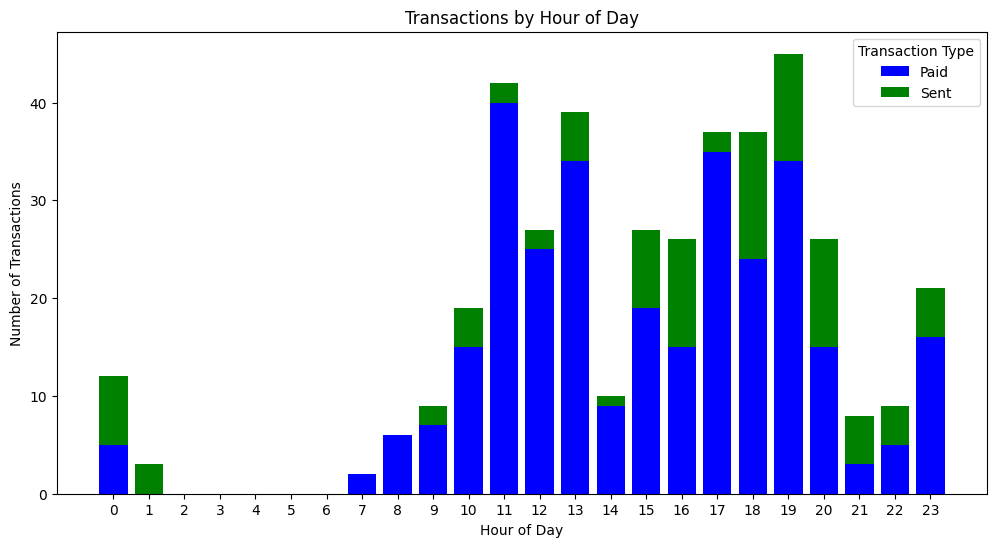

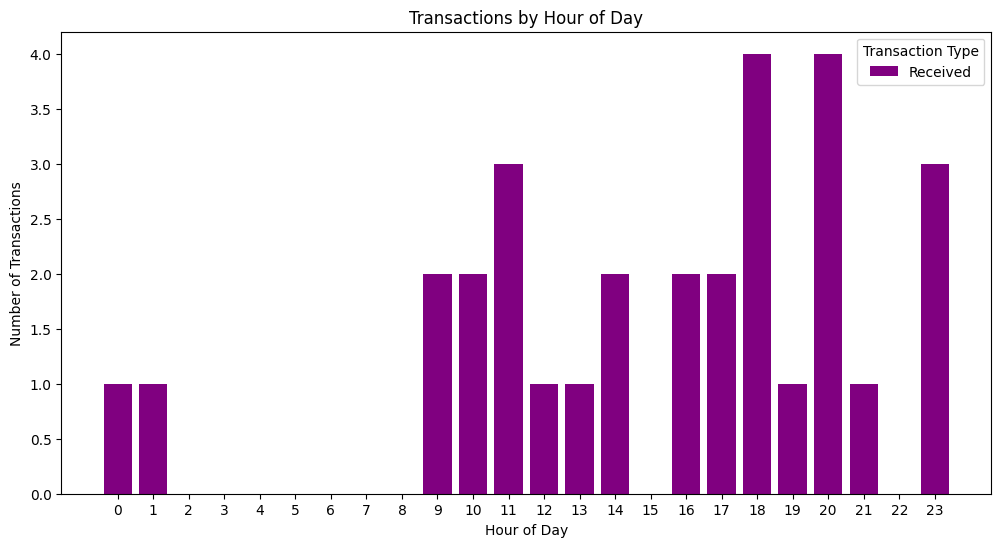

In [32]:



pivot_df = hourly_transactions.pivot(index="Hour", columns="Transaction Type", values="Count").fillna(0)
#print(pivot_df)
plt.figure(figsize=(12, 6))
plt.bar(pivot_df.index, pivot_df["Paid"], label="Paid", color="blue")
plt.bar(pivot_df.index, pivot_df["Sent"], bottom=pivot_df["Paid"], label="Sent", color="green")
plt.title('Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(24))
plt.legend(title='Transaction Type')
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(pivot_df.index, pivot_df["Received"], label="Received", color="purple")

plt.title('Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(24))
plt.legend(title='Transaction Type')
plt.show()

##Daily Graph

In [ ]:




day_transactions = df.groupby('Day').size().reset_index(name='Count')
day_transactions = df.groupby('Day').size().reset_index(name='Count')

kuch = df.groupby('Day').sum('Amount')
print(day_transactions)
print(kuch)

In [44]:
#Extracting day wise
df['Day'] = df['Date'].dt.day

day_transactions = df.groupby('Day').agg(
    Count=('Payee', 'size'),
    Amount=('Amount', 'sum')
).reset_index()
print(day_transactions)

    Day  Count    Amount
0     1      9    588.28
1     2     14   2296.54
2     3     12   1263.00
3     4     15   4467.00
4     5      9    898.00
5     6      8   6166.00
6     7     18   3567.00
7     8     13   2978.00
8     9     12   1063.00
9    10     18   9583.90
10   11     10    790.00
11   12     12   1396.00
12   13     10   1746.54
13   14     11    896.00
14   15     23   8655.50
15   16     19  23230.01
16   17     14   1391.00
17   18     20   6433.00
18   19      7   2306.00
19   20      9   7777.00
20   21     36  23394.60
21   22     18   2340.00
22   23     20   3514.00
23   24      8    847.00
24   25     15   2113.00
25   26      9    618.00
26   27     25   6384.00
27   28     13   2145.86
28   29      5    233.00
29   30     17  12948.00
30   31      6    754.15


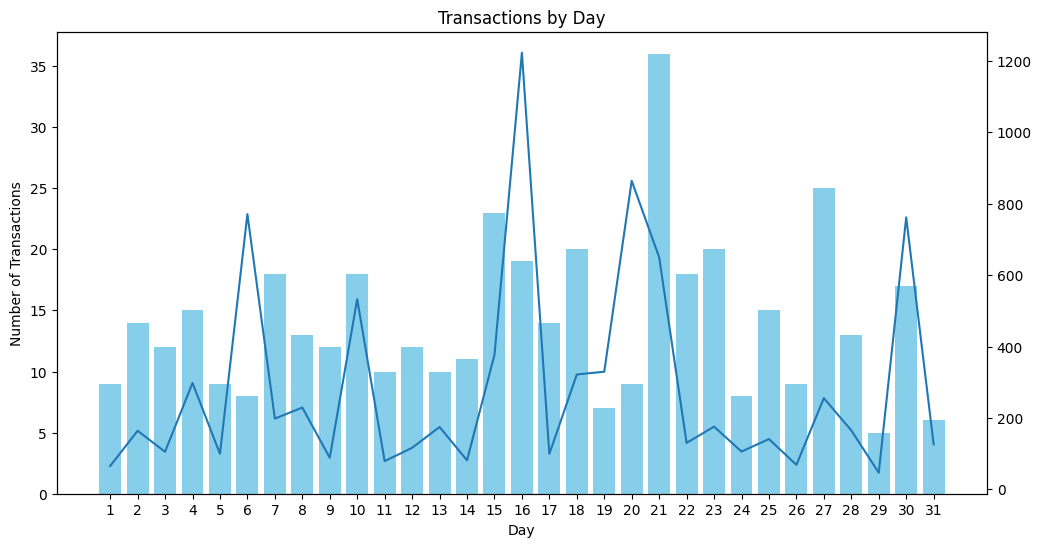

In [49]:

fig, ax1 = plt.subplots(figsize=(12, 6))



ax1.bar(day_transactions['Day'], day_transactions['Count'], color='skyblue')
plt.xlabel('Day')
plt.xticks(range(1, 32))  # Assuming days are from 1 to 31
plt.ylabel('Number of Transactions')
plt.title('Transactions by Day')

ax2 = ax1.twinx()

ax2.plot(day_transactions['Day'],day_transactions['Amount']/day_transactions['Count'])


plt.show()

## Monthly Graph

    Month  Count
0       1     48
1       2     48
2       3     44
3       4     44
4       5     59
5       6     11
6       7     18
7       8     43
8       9     41
9      10     24
10     11     19
11     12     36


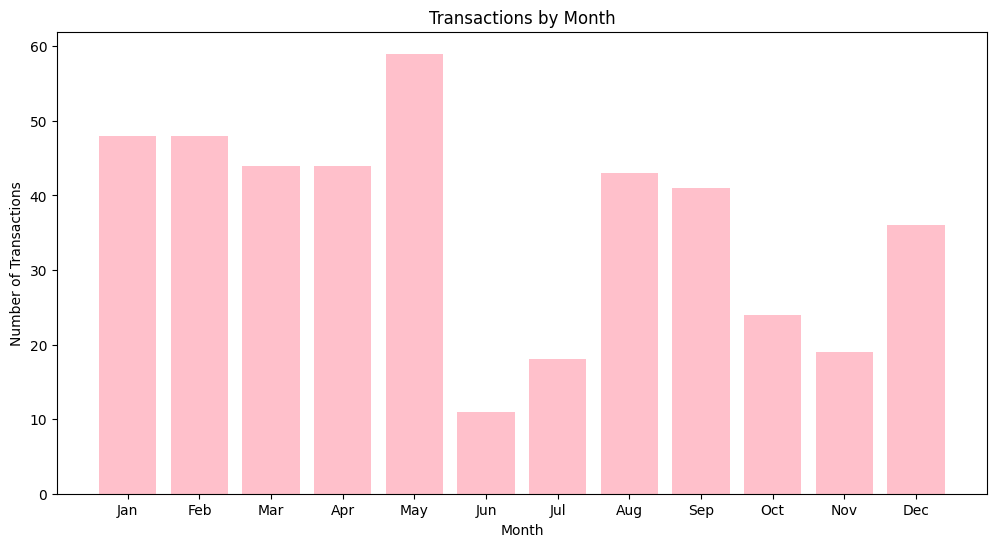

In [ ]:
df['Month'] = df['Date'].dt.month
monthly_transactions = df.groupby('Month').size().reset_index(name='Count')
print(monthly_transactions)


#if dataset given has data for 2 months of jan but only 1 july total transaction dont paint the correct picture hence it should be average

plt.figure(figsize=(12, 6))
plt.bar(monthly_transactions['Month'],monthly_transactions['Count'], color='pink')
plt.xlabel('Month')
tick_positions = range(1, 13)
tick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.ylabel('Number of Transactions')
plt.title('Transactions by Month')
plt.show()





---



#Removing outliers
automated and manual

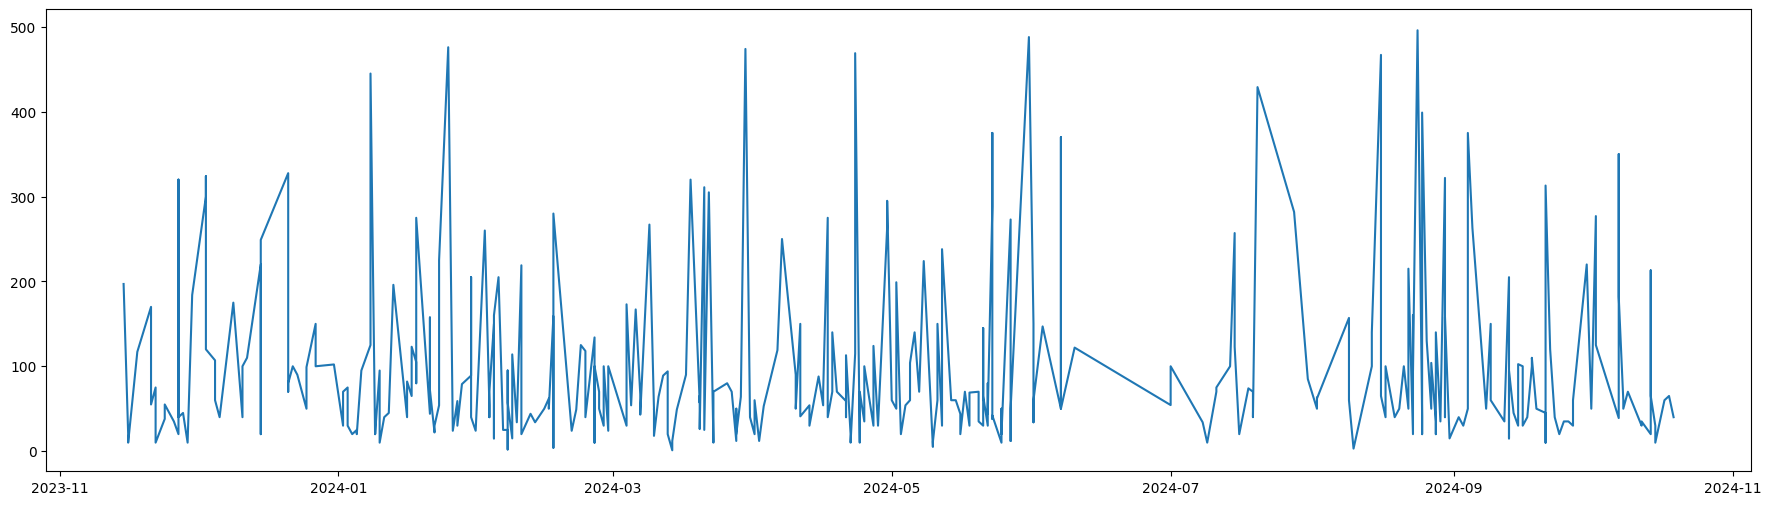

In [36]:

amount_ceil = 500
amount_floor = 0
#plt.figure(figsize=(12, 20))
#plt.boxplot(df[df['Amount'] < amount_ceil && df['Amount'] > amount_floor]['Amount'])

df_limited = df[(df['Amount'] < amount_ceil) & (df['Amount'] > amount_floor)]
plt.figure(figsize=(22, 6))
plt.plot(df_limited['Date'],df_limited['Amount'])


plt.show()


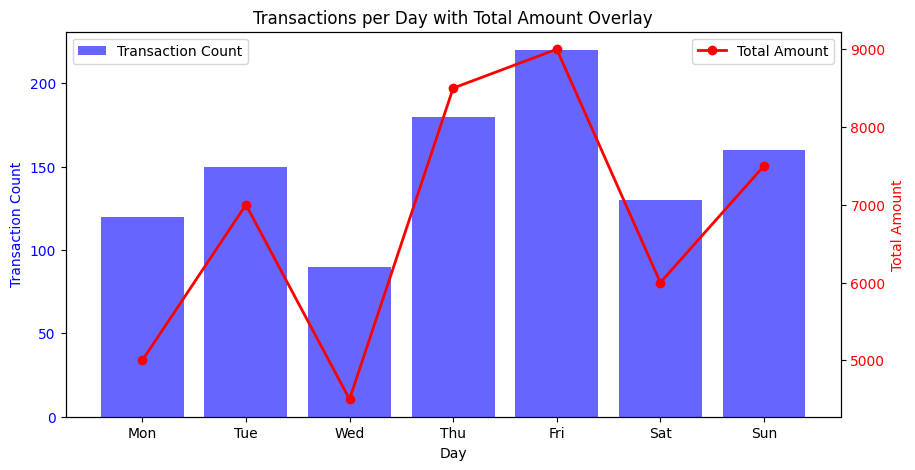

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
transaction_count = [120, 150, 90, 180, 220, 130, 160]  # Bar chart (left y-axis)
total_amount = [5000, 7000, 4500, 8500, 9000, 6000, 7500]  # Line chart (right y-axis)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart (Transaction Count)
ax1.bar(days, transaction_count, color='blue', alpha=0.6, label='Transaction Count')
ax1.set_xlabel('Day')
ax1.set_ylabel('Transaction Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()

# Line chart (Total Amount)
ax2.plot(days, total_amount, color='red', marker='o', linestyle='-', linewidth=2, label='Total Amount')
ax2.set_ylabel('Total Amount', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Transactions per Day with Total Amount Overlay')
plt.show()
